<a href="https://colab.research.google.com/github/ag4626250/GradCam-procesamiento/blob/main/gradCam_presentaci%C3%B3n_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers torch safetensors opencv-python Pillow  # instala libs

from transformers import AutoImageProcessor, AutoModelForImageClassification  # modelo HF
from PIL import Image  # manejo de imágenes
import numpy as np  # arrays y mapas
import torch  # tensores
import base64  # codificar imagen
from io import BytesIO  # buffer en memoria
import cv2  # colormap y overlay


In [ ]:
model_id = "Anwarkh1/Skin_Cancer-Image_Classification"  # id del modelo
processor = AutoImageProcessor.from_pretrained(model_id)  # processor HF
model = AutoModelForImageClassification.from_pretrained(model_id, output_attentions=True)  # modelo ViT
model.set_attn_implementation("eager")  # atención en modo eager para obtener mapas
model.eval()  # modo evaluación


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
from IPython.display import display  # para mostrar imágenes en Colab

def overlay_heatmap(heatmap, image, alpha=0.6):  # mezcla mapa e imagen
    heatmap = cv2.resize(heatmap, image.size)  # adapta tamaño al original
    heatmap = cv2.GaussianBlur(heatmap, (7, 7), 0)  # suaviza mapa
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)  # normaliza 0-1
    heatmap = (255 * heatmap).astype("uint8")  # pasa a 0-255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_INFERNO)  # aplica colormap inferno
    img_np = np.array(image.convert("RGB"))[..., ::-1]  # PIL RGB → BGR
    overlay = cv2.addWeighted(heatmap, alpha, img_np, 1 - alpha, 0)  # mezcla mapa e imagen
    overlay = overlay[..., ::-1]  # BGR → RGB
    overlay_img = Image.fromarray(overlay)  # vuelve a PIL
    return overlay_img  # devolvemos la imagen resultante


In [ ]:
def compute_cam_multi(attentions, last_k=4):  # attention×grad sobre varias capas
    last_k = min(last_k, len(attentions))  # limita a nº de capas disponible
    cams = []  # lista de mapas por capa
    for attn in attentions[-last_k:]:  # últimas k capas
        grad = attn.grad  # gradiente de la atención
        attn_cls = attn[:, :, 0, 1:]  # atención CLS→patches
        grad_cls = grad[:, :, 0, 1:]  # gradiente CLS→patches
        cam = (attn_cls * grad_cls).mean(dim=1)  # media sobre cabezas
        cam = cam[0].detach().cpu().numpy()  # quita batch
        cams.append(cam)  # guarda mapa de esa capa
    cam = np.mean(cams, axis=0)  # promedio sobre capas
    cam = np.maximum(cam, 0)  # ReLU
    cam = cam / (cam.max() + 1e-8)  # normaliza 0–1
    side = int(cam.size ** 0.5)  # lado de la cuadrícula de patches
    return cam.reshape(side, side)  # mapa 2D


In [ ]:
def analyze_image(image_path):  # predicción + heatmap multi-capa
    img = Image.open(image_path).convert("RGB")  # abre imagen original
    inputs = processor(images=img, return_tensors="pt")  # prepara tensores

    with torch.no_grad():  # primera pasada sin gradientes
        out = model(**inputs)  # forward estándar
        probs = torch.softmax(out.logits, dim=1)  # probabilidades
        cls_id = int(torch.argmax(probs, dim=1).item())  # índice de clase
        prob = float(probs[0, cls_id].item())  # probabilidad

    inputs = processor(images=img, return_tensors="pt")  # nueva copia
    inputs["pixel_values"].requires_grad_()  # activa gradiente en pixel_values
    out = model(**inputs, output_attentions=True, return_dict=True)  # forward con atenciones
    attentions = out.attentions  # lista de atenciones
    for attn in attentions:  # recorre cada capa
        attn.retain_grad()  # guarda gradiente de la atención
    logit = out.logits[0]  # logits de la imagen
    logit[cls_id].backward()  # backprop sobre la clase elegida
    cam = compute_cam_multi(attentions, last_k=4)  # heatmap multi-capa
    overlay = overlay_heatmap(cam, img)  # imagen con heatmap
    display(img)  # muestra imagen original
    display(overlay)  # muestra imagen con Grad-CAM
    label = model.config.id2label[int(cls_id)]  # mapea índice a nombre de clase :contentReference[oaicite:0]{index=0}
    return cls_id, label, prob  # devuelve índice, nombre y probabilidad



In [ ]:
#Esta celda si que se tiene que ejecutar para el código original ya que te perimte selccionar una imagen del ordenador y te da las diferentes salidas!!!!



# from google.colab import files  # para subir archivos

# uploaded = files.upload()  # abre diálogo de subida
# image_path = list(uploaded.keys())[0]  # coge el nombre del archivo
# print("Imagen subida:", image_path)  # confirma nombre

# cls_id, label, prob = analyze_image(image_path)  # ejecuta análisis completo

# print("Predicción (clase):", cls_id)  # muestra índice de clase
# print("Categoría:", label)  # muestra nombre de categoría
# print("Probabilidad:", f"{prob*100:.2f}%")  # probabilidad en porcentaje


## Código histórico de Grad-CAM (no forma parte de la versión final)

Las celdas que aparecen a continuación **no forman parte de la implementación final que usamos**, sino que recogen **versiones antiguas de Grad-CAM** que probamos inicialmente en VSCode y que después hemos traído aquí solo para poder generar las figuras de comparación de la presentación.

En concreto, se incluyen dos variantes históricas:

- **Grad-CAM solo última capa de atención**  
  - Usa *attention × gradient* pero únicamente sobre la **última capa** del ViT.  
  - Funciona razonablemente bien, pero los mapas son más **inestables** y sensibles a pequeñas variaciones, porque dependen de una sola capa.

- **Grad-CAM “antiguo” (embeddings + overlay rojo-azul)**  
  - Calcula Grad-CAM a partir de los **embeddings del último bloque** y los superpone con un colormap rojo-azul sencillo.  
  - Esta versión produce mapas mucho más **ruidosos y difíciles de interpretar**, porque los embeddings no conservan tan claramente la estructura espacial y la visualización es más tosca.

Estas dos configuraciones se conservan aquí **solo con fines ilustrativos**, para mostrar cómo han ido mejorando los mapas de activación hasta llegar a la versión que consideramos correcta.


In [ ]:
def compute_cam_last(attentions):  # solo última capa
    attn = attentions[-1]               # última capa [B,H,T,T]
    grad = attn.grad                    # gradiente de esa capa [B,H,T,T]
    attn_cls = attn[:, :, 0, 1:]        # atención CLS→patches [B,H,T-1]
    grad_cls = grad[:, :, 0, 1:]        # gradiente CLS→patches [B,H,T-1]
    cam = (attn_cls * grad_cls).mean(dim=1)  # media sobre cabezas [B,T-1]
    cam = cam[0].detach().cpu().numpy()     # quita batch
    cam = np.maximum(cam, 0)                # ReLU
    cam = cam / (cam.max() + 1e-8)          # normaliza 0–1
    side = int(cam.size ** 0.5)             # lado cuadrícula
    return cam.reshape(side, side)          # mapa 2D


In [ ]:
def analyze_image_last_layer(image_path):  # ATT×GRAD solo última capa
    img = Image.open(image_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt")

    # 1) pasada sin gradiente para sacar clase y prob
    with torch.no_grad():
        out = model(**inputs)
        probs = torch.softmax(out.logits, dim=1)
        cls_id = int(torch.argmax(probs, dim=1).item())
        prob = float(probs[0, cls_id].item())
        label = model.config.id2label[cls_id]

    # 2) pasada con gradientes y atenciones
    inputs = processor(images=img, return_tensors="pt")
    inputs["pixel_values"].requires_grad_()
    out = model(**inputs, output_attentions=True, return_dict=True)
    attentions = out.attentions
    attn = attentions[-1]
    attn.retain_grad()  # solo guardo gradiente de la última capa
    logit = out.logits[0]
    logit[cls_id].backward()

    cam = compute_cam_last(attentions)   # solo última capa
    overlay = overlay_heatmap(cam, img)  # overlay con tu función actual

    display(img)       # imagen original
    display(overlay)   # imagen con Grad-CAM
    print("Predicción (última capa) ->", label, f"({prob*100:.2f}%)")
    return cls_id, label, prob


In [ ]:
class ViTGradCAMEmbeddings:  # Grad-CAM sobre embeddings del último bloque
    def __init__(self, model):
        self.model = model
        self.activ = None   # activaciones [B,T,D]
        self.grads = None   # gradientes [B,T,D]
        blk = model.vit.encoder.layer[-1].output  # salida del último bloque encoder
        blk.register_forward_hook(self._save_activ)          # guarda activaciones
        blk.register_full_backward_hook(self._save_grads)    # guarda gradientes

    def _save_activ(self, module, inp, out):
        self.activ = out[0]  # [B,T,D]

    def _save_grads(self, module, grad_in, grad_out):
        self.grads = grad_out[0]  # [B,T,D]

    def generate(self, inputs, class_idx):
        self.model.zero_grad()
        out = self.model(**inputs)         # forward normal
        logits = out.logits               # [B,num_clases]
        score = logits[:, class_idx]      # logit de la clase objetivo
        score.backward()                  # backprop
        grads = self.grads                # [B,T,D]
        activ = self.activ                # [B,T,D]
        weights = grads.mean(dim=1)       # media sobre tokens → [B,D]
        token_cam = (activ * weights[:, None, :]).sum(dim=-1)  # [B,T]
        token_cam = token_cam[0, 1:]      # quitamos CLS → [T-1]
        side = int(token_cam.numel() ** 0.5)
        cam = token_cam.reshape(side, side).detach().cpu().numpy()
        cam = np.maximum(cam, 0)
        cam = cam / (cam.max() + 1e-8)
        return cam  # 2D, normalizado


In [ ]:
def analyze_image_embeddings(image_path):  # Grad-CAM sobre embeddings
    img = Image.open(image_path).convert("RGB")
    inputs = processor(images=img, return_tensors="pt")

    # predicción normal
    with torch.no_grad():
        out = model(**inputs)
        probs = torch.softmax(out.logits, dim=1)
        cls_id = int(torch.argmax(probs, dim=1).item())
        prob = float(probs[0, cls_id].item())
        label = model.config.id2label[cls_id]

    # Grad-CAM con embeddings
    inputs = processor(images=img, return_tensors="pt")
    cam = vit_cam_emb.generate(inputs, cls_id)   # mapa 2D
    overlay = overlay_heatmap(cam, img)          # usamos el mismo overlay

    display(img)       # original
    display(overlay)   # Grad-CAM “viejo”
    print("Predicción (embeddings) ->", label, f"({prob*100:.2f}%)")
    return cls_id, label, prob


In [ ]:
# def overlay_embed_raw(cam, image, alpha=0.5):
#     """Overlay sencillo tipo versión inicial (sin colormap ni blur)."""
#     cam = np.clip(cam, 0.0, 1.0)  # asegura 0-1
#     cam_img = Image.fromarray(np.uint8(cam * 255))  # escala a 0-255 en gris
#     cam_img = cam_img.resize(image.size, Image.NEAREST)  # reescala sin suavizar
#     cam_rgb = cam_img.convert("RGB")  # pasa a RGB simple (gris sobre 3 canales)
#     overlay = Image.blend(image, cam_rgb, alpha=alpha)  # mezcla directa
#     return overlay


In [ ]:
# import matplotlib.cm as cm

# def embedding_heatmap_pure(cam, image, blur=True):
#     """
#     Heatmap estilo 'viejo': fondo morado y puntos naranja,
#     sin mezclar con la piel.
#     """
#     cam = np.clip(cam, 0.0, 1.0)  # asegura 0-1
#     heatmap = cv2.resize(cam, image.size)  # reescala a tamaño imagen

#     if blur:
#         heatmap = cv2.GaussianBlur(heatmap, (7, 7), 0)  # suave

#     # normalizamos y levantamos un poco el mínimo para evitar negro puro
#     heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
#     heatmap = 0.2 + 0.8 * heatmap  # ahora va de 0.2 a 1.0

#     # aplicamos colormap 'plasma' (morado → naranja)
#     cmap = cm.get_cmap("plasma")  # también puedes probar "inferno", "magma", etc.
#     colored = cmap(heatmap)[:, :, :3]  # RGB en [0,1], ignoramos alfa
#     colored_uint8 = (colored * 255).astype("uint8")  # 0-255

#     return Image.fromarray(colored_uint8)  # imagen PIL solo del mapa



In [ ]:
def compute_cam_old(attn):  # attention × gradient sobre ÚLTIMA capa (versión antigua)
    grad = attn.grad  # [B,H,T,T]
    attn_cls = attn[:, :, 0, 1:]  # CLS→patches [B,H,T-1]
    grad_cls = grad[:, :, 0, 1:]  # gradiente CLS→patches [B,H,T-1]
    cam = (attn_cls * grad_cls).mean(dim=1)  # media sobre cabezas [B,T-1]
    cam = cam[0].detach().cpu().numpy()  # quita batch
    cam = np.maximum(cam, 0)  # ReLU
    cam = cam / (cam.max() + 1e-8)  # normaliza 0-1
    side = int(cam.size ** 0.5)  # lado cuadrícula
    return cam.reshape(side, side)  # mapa 2D


def colorize_cam_old(cam, size):  # colormap rojo-azul “cutre” original
    cam = np.clip(cam, 0.0, 1.0)  # asegura rango
    cam_img = Image.fromarray(np.uint8(cam * 255))  # 0-255
    cam_img = cam_img.resize(size, Image.BILINEAR)  # reescala
    cam_np = np.asarray(cam_img, dtype=np.float32) / 255.0  # 0-1
    cam_np = cam_np ** 1.5  # realza activaciones altas
    r = (cam_np * 255).astype(np.uint8)  # canal rojo
    g = np.zeros_like(r)  # canal verde a cero
    b = ((1.0 - cam_np) * 255).astype(np.uint8)  # canal azul
    rgb = np.stack([r, g, b], axis=-1)  # une canales
    return Image.fromarray(rgb)  # imagen RGB


In [ ]:
import matplotlib.pyplot as plt
import os  # asegúrate de tener este import

def show_all_gradcams_row(image_path):
    img = Image.open(image_path).convert("RGB")

    # 1) Clase y probabilidad
    inputs = processor(images=img, return_tensors="pt")
    with torch.no_grad():
        out = model(**inputs)
        probs = torch.softmax(out.logits, dim=1)
        cls_id = int(torch.argmax(probs, dim=1).item())
        prob = float(probs[0, cls_id].item())
        label = model.config.id2label[cls_id]

    # 2) Forward con atenciones y gradientes
    inputs = processor(images=img, return_tensors="pt")
    inputs["pixel_values"].requires_grad_()
    out = model(**inputs, output_attentions=True, return_dict=True)
    attentions = out.attentions
    for attn in attentions:
        attn.retain_grad()
    logit = out.logits[0]
    logit[cls_id].backward()

    cam_multi = compute_cam_multi(attentions, last_k=4)
    overlay_multi = overlay_heatmap(cam_multi, img)

    cam_last = compute_cam_last(attentions)
    overlay_last = overlay_heatmap(cam_last, img)

    attn_last = attentions[-1]
    cam_old = compute_cam_old(attn_last)
    cam_color_old = colorize_cam_old(cam_old, img.size)
    overlay_old = Image.blend(img, cam_color_old, alpha=0.4)

    fig, axes = plt.subplots(1, 4, figsize=(22, 6))
    fig.patch.set_alpha(0.0)

    imgs = [img, overlay_multi, overlay_last, overlay_old]
    texts = [
        "Original",
        f"Multi-capa (4 últimas)\n{label}\n{prob*100:.1f}%",
        f"Solo última capa\n{label}\n{prob*100:.1f}%",
        f"Grad-CAM antiguo\n{label}\n{prob*100:.1f}%"
    ]

    for ax, im, txt in zip(axes, imgs, texts):
        ax.imshow(im)
        ax.axis("off")
        ax.text(
            0.5, -0.03, txt,
            transform=ax.transAxes,
            ha="center", va="top",
            fontsize=12,
            fontweight="bold"
        )

    plt.subplots_adjust(left=0.02, right=0.98, top=0.97, bottom=0.10, wspace=0.05)
    plt.show()

    # ---------- NUEVO: guardado automático ----------
    base = os.path.splitext(os.path.basename(image_path))[0]
    out_path = f"gradcam_{base}.png"
    fig.savefig(out_path, bbox_inches="tight", transparent=True, dpi=300)
    print("Figura guardada en:", out_path)
    # -------------------------------------------------

    return out_path  # por si lo quieres usar luego


Saving ISIC_0077778.jpg to ISIC_0077778.jpg
Imagen subida: ISIC_0077778.jpg


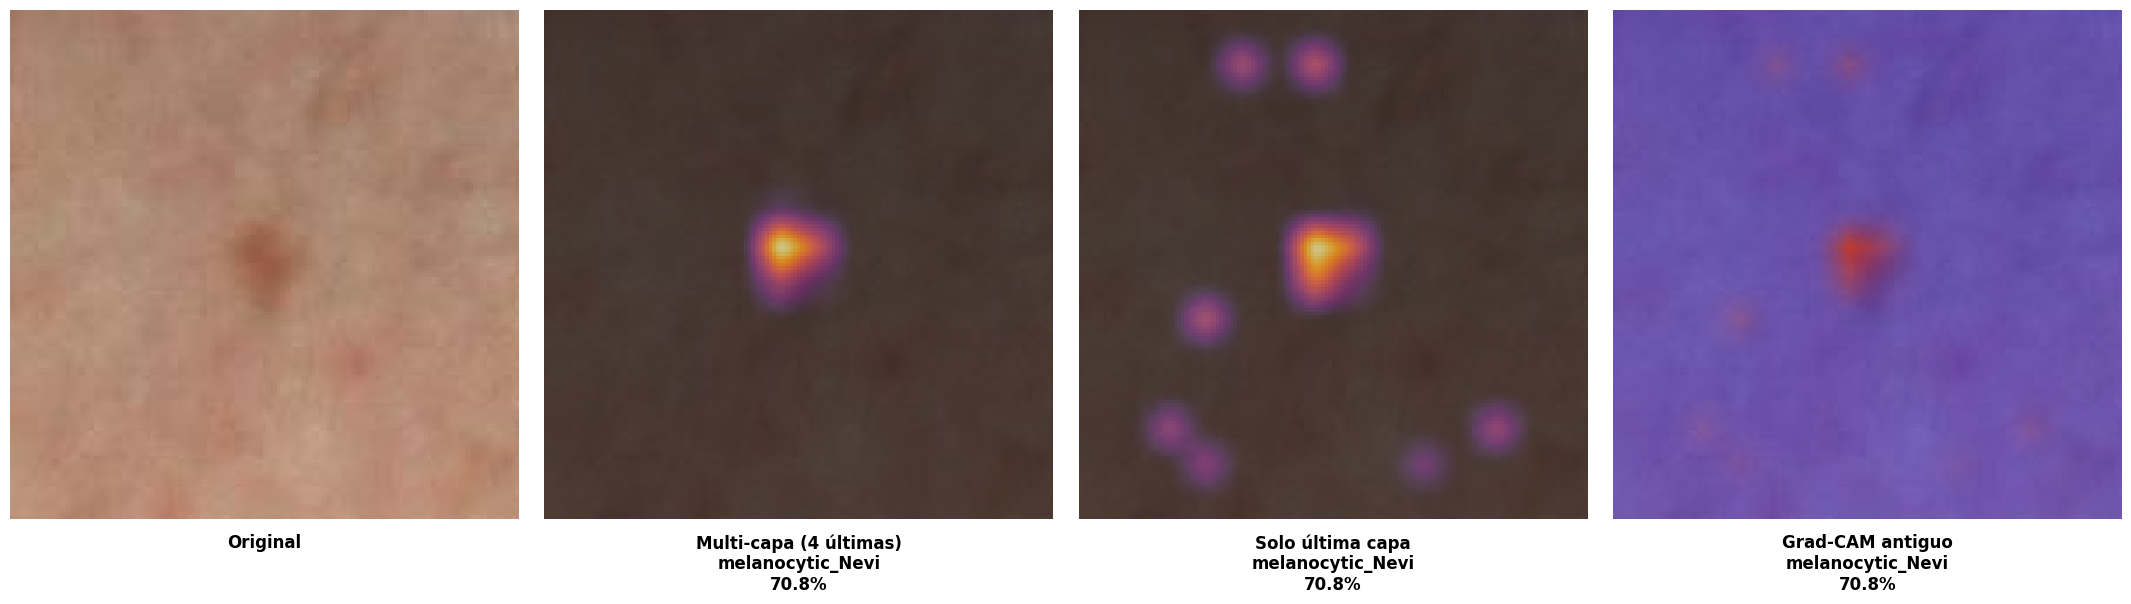

Figura guardada en: gradcam_ISIC_0077778.png


In [ ]:
from google.colab import files

def probar_nueva_imagen():
    uploaded = files.upload()          # eliges archivo
    image_path = list(uploaded.keys())[0]
    print("Imagen subida:", image_path)
    show_all_gradcams_row(image_path)  # genera las 4 figuras

# Llamada
probar_nueva_imagen()


In [ ]:
import matplotlib.pyplot as plt
import os

def show_multicam_pair(image_path):
    """
    Comparación simple:
    - Izquierda: imagen original
    - Derecha: Grad-CAM final (multi-capa, 4 últimas capas)
    Con texto debajo y guardado en PNG.
    """
    img = Image.open(image_path).convert("RGB")

    # 1) Clase y probabilidad
    inputs = processor(images=img, return_tensors="pt")
    with torch.no_grad():
        out = model(**inputs)
        probs = torch.softmax(out.logits, dim=1)
        cls_id = int(torch.argmax(probs, dim=1).item())
        prob = float(probs[0, cls_id].item())
        label = model.config.id2label[cls_id]

    # 2) Forward con atenciones y gradientes (multi-capa)
    inputs = processor(images=img, return_tensors="pt")
    inputs["pixel_values"].requires_grad_()
    out = model(**inputs, output_attentions=True, return_dict=True)
    attentions = out.attentions
    for attn in attentions:
        attn.retain_grad()
    logit = out.logits[0]
    logit[cls_id].backward()

    cam_multi = compute_cam_multi(attentions, last_k=4)
    overlay_multi = overlay_heatmap(cam_multi, img)

    # 3) Figura con texto debajo (mismo estilo que la de 4 columnas)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.patch.set_alpha(0.0)

    imgs = [img, overlay_multi]
    texts = [
        "Original",
        f"Grad-CAM (4 últimas capas)\n{label}\n{prob*100:.1f}%"
    ]

    for ax, im, txt in zip(axes, imgs, texts):
        ax.imshow(im)
        ax.axis("off")
        ax.text(
            0.5, -0.03, txt,
            transform=ax.transAxes,
            ha="center", va="top",
            fontsize=12,
            fontweight="bold"
        )

    plt.subplots_adjust(left=0.02, right=0.98, top=0.97, bottom=0.10, wspace=0.05)
    plt.show()

    # Guardar figura para la diapositiva
    base = os.path.splitext(os.path.basename(image_path))[0]
    out_path = f"gradcam_pair_{base}.png"
    fig.savefig(out_path, bbox_inches="tight", transparent=True, dpi=300)
    print("Figura guardada en:", out_path)
    return out_path


Saving ISIC_3243092.jpg to ISIC_3243092.jpg
Imagen (mala) subida: ISIC_3243092.jpg


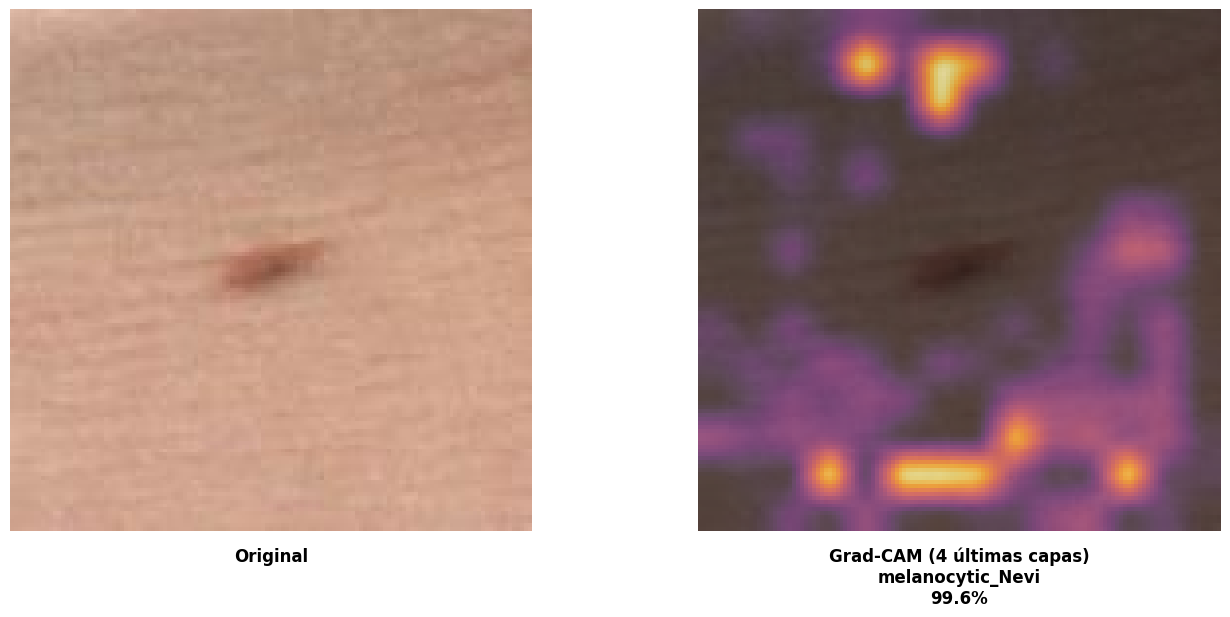

Figura guardada en: gradcam_pair_ISIC_3243092.png


'gradcam_pair_ISIC_3243092.png'

In [ ]:
from google.colab import files

uploaded = files.upload()                 # seleccionas la imagen mala
bad_path = list(uploaded.keys())[0]
print("Imagen (mala) subida:", bad_path)

show_multicam_pair(bad_path)
